# Generating Zonal Statistics with a Custom Script
This notebook demonstrates how to generate zonal statistics using a custom Python script, with a focus on analyzing night light intensity across administrative regions in Rwanda. You will learn how to set up your workspace, import and prepare geospatial data, clip global raster datasets to a country boundary, and visualize the results. The workflow includes using custom utilities for zonal statistics, merging results with administrative boundaries, and saving the outputs for further analysis. This hands-on approach provides practical experience with geospatial data processing, raster analysis, and the integration of Python geospatial libraries such as geopandas and rasterio.

**Zonal statistics** are summary statistics (such as mean, sum, median, minimum, or maximum) calculated for values of a raster dataset within the boundaries of defined zones, such as polygons representing administrative regions or land cover types.


## Setup and Imports

In [5]:
from osgeo import gdal

### Required Packages

In [6]:
from osgeo import gdal
import geopandas, rasterio, pandas, numpy, matplotlib, seaborn, jupyter
print("All packages imported successfully!")
print(f"GDAL version: {gdal.__version__}")
print(f"GeoPandas version: {geopandas.__version__}")
print(f"Rasterio version: {rasterio.__version__}")
print(f"Pandas version: {pandas.__version__}")
print(f"Numpy version: {numpy.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {seaborn.__version__}")
print(f"Jupyter version: {jupyter.__version__}")

Note: you may need to restart the kernel to use updated packages.
All packages imported successfully!
GDAL version: 3.11.3
GeoPandas version: 0.12.2
Rasterio version: 1.3.6
Pandas version: 1.5.3
Numpy version: 1.24.3
Matplotlib version: 3.6.3
Seaborn version: 0.12.2
Jupyter version: 1.0.0


In [6]:
%pip install --upgrade numpy pandas geopandas rasterio fiona matplotlib seaborn

import sys
from pathlib import Path
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
#import seaborn as sns
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import warnings
import fiona
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


### Workspace Directory Setup

In [7]:
from pathlib import Path

In [39]:
# Current working directory
cwd = Path.cwd()
print("Current working directory:", cwd)

# Parent directory of the working directory
parent = cwd.parent
print("Parent directory:", parent)

Current working directory: /Users/ekayitaba/Documents/GitHub/nightlight-analysis-emmanuel.kayitaba
Parent directory: /Users/ekayitaba/Documents/GitHub


In [8]:
DIR_WORKSPACE = Path.cwd()
DIR_DATA = DIR_WORKSPACE / "data"
DIR_SRC = DIR_WORKSPACE / "src"

### Import Custom Python Script

In [9]:
# Add src directory to path to import our custom script
sys.path.append(str(DIR_SRC))


In [10]:
import spatial_utils

In [11]:
# We can now import our custom package
# There are cleaner ways to handle local imports but this works for now
from rasterstats import zonal_stats

### Input Data Files 
For the night lights file, please make sure you unzip it first. 

In [12]:
# ==========================================
# FILE PATHS
# ===========================================

# Unzipped night lights raster file with "tif" extension
FILE_NTL = DIR_DATA / "ntl/VNL_npp_2024_global_vcmslcfg_v2_c202502261200.average_masked.dat.tif"

# Shapefile with cell level (admin region level 4) boundaries 
FILE_SHP_ADM4 = DIR_DATA / "geospatial/pop-demo-infra/adm4-pop-buildings.shp"

# Shapefile with national boundaries (admin region level 0)
FILE_SHP_ADM0 = DIR_DATA / "geospatial/adm-bounds/geoBoundaries-RWA-ADM0-all/geoBoundaries-RWA-ADM0.shp"

## Zonal Statistics Analysis

### Clip Global Raster to Rwanda 
To make the raster file smaller and more manageable, we will clip (cut) it to the boundary of Rwanda. This step extracts only the portion of the raster that falls within Rwanda’s borders, reducing file size and improving processing efficiency.

In [13]:
def clip_raster_to_boundary(input_raster_path, boundary_gdf, output_path):
    """
    Clip a global raster to a country boundary
    
    Parameters:
    -----------
    input_raster_path : str
        Path to input raster file
    boundary_gdf : geopandas.GeoDataFrame
        Boundary for clipping
    output_path : str
        Path for output clipped raster
    
    Returns:
    --------
    str : Path to clipped raster
    """
    print(f"Clipping global raster to Rwanda boundary...")
    
    with rasterio.open(input_raster_path) as src:
        print(f"Original raster info:")
        print(f"  - Shape: {src.width} x {src.height}")
        print(f"  - CRS: {src.crs}")
        print(f"  - Bounds: {src.bounds}")
        print(f"  - Resolution: {src.res}")
        
        # Reproject boundary to match raster CRS if needed
        if boundary_gdf.crs != src.crs:
            print(f"Reprojecting boundary from {boundary_gdf.crs} to {src.crs}")
            boundary_gdf = boundary_gdf.to_crs(src.crs)
        
        # Clip raster
        clipped_data, clipped_transform = mask(
            src, 
            boundary_gdf.geometry, 
            crop=True,
            nodata=src.nodata
        )
        
        # Update metadata
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "driver": "GTiff",
            "height": clipped_data.shape[1],
            "width": clipped_data.shape[2],
            "transform": clipped_transform
        })
        
        # Create output directory if needed
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Write clipped raster
        with rasterio.open(output_path, "w", **clipped_meta) as dest:
            dest.write(clipped_data)
        
        print(f"✓ Clipped raster saved to: {output_path}")
        print(f"Clipped raster info:")
        print(f"  - Shape: {clipped_data.shape[2]} x {clipped_data.shape[1]}")
        print(f"  - Data range: {np.nanmin(clipped_data)} to {np.nanmax(clipped_data)}")
        
    return output_path

corrected version

### Visualize Clipped Raster

In [65]:
import os
from pathlib import Path

import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.ops import unary_union

def clip_raster_to_boundary(input_raster_path, boundary_gdf, output_path):
    """
    Clip a raster to a boundary (GeoDataFrame polygons).

    Parameters
    ----------
    input_raster_path : str | Path
        Path to input raster file.
    boundary_gdf : geopandas.GeoDataFrame
        Polygon boundary/boundaries to clip to.
    output_path : str | Path
        Path for output clipped raster (GeoTIFF).

    Returns
    -------
    str
        Path to clipped raster.
    """
    input_raster_path = Path(input_raster_path)
    output_path = Path(output_path)

    print("Clipping raster to boundary…")
    with rasterio.open(input_raster_path) as src:
        print("Original raster info:")
        print(f"  - Size: {src.width} x {src.height} (W x H)")
        print(f"  - Bands: {src.count}")
        print(f"  - CRS: {src.crs}")
        print(f"  - Bounds: {src.bounds}")
        print(f"  - Resolution: {src.res}")
        print(f"  - Dtype: {src.dtypes[0]}")
        print(f"  - NODATA: {src.nodata}")

        # 1) Ensure boundary GeoDataFrame is valid & same CRS
        if boundary_gdf.crs != src.crs:
            print(f"Reprojecting boundary from {boundary_gdf.crs} → {src.crs}")
            boundary_gdf = boundary_gdf.to_crs(src.crs)

        # Drop empties / fix invalids
        boundary = boundary_gdf.geometry
        boundary = boundary[boundary.notna() & (~boundary.is_empty)]
        if len(boundary) == 0:
            raise ValueError("Boundary has no valid geometries after cleaning.")

        # Dissolve to one geometry to avoid tiny slivers/holes
        dissolved = unary_union(boundary)
        # Some invalids get fixed by a zero-width buffer
        if not dissolved.is_valid:
            dissolved = dissolved.buffer(0)

        shapes = [mapping(dissolved)]  # GeoJSON-like for rasterio.mask

        # 2) Clip
        clipped_data, clipped_transform = mask(
            src,
            shapes,
            crop=True,
            nodata=src.nodata,   # preserve nodata if set
            filled=True          # fill outside with nodata
        )

        # 3) Prepare output metadata
        meta = src.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": clipped_data.shape[1],
            "width":  clipped_data.shape[2],
            "transform": clipped_transform,
            "compress": "deflate",
            "tiled": True,
            "bigtiff": "IF_SAFER",
        })
        # Ensure CRS & nodata kept
        if src.crs is not None:
            meta["crs"] = src.crs
        # If nodata is missing but dtype is integer, choose a nodata value
        if meta.get("nodata", None) is None:
            if np.issubdtype(np.dtype(meta["dtype"]), np.integer):
                meta["nodata"] = 0  # pick a reasonable integer nodata
            else:
                # For float rasters, nodata can be NaN; rasterio stores it as None in metadata.
                pass

    # 4) Write output
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(output_path, "w", **meta) as dest:
        dest.write(clipped_data)

    # 5) Stats (ignore nodata safely)
    nodata_val = meta.get("nodata", None)
    data_for_stats = clipped_data.astype("float64", copy=False)
    if nodata_val is not None:
        data_for_stats = np.where(data_for_stats == nodata_val, np.nan, data_for_stats)

    finite = np.isfinite(data_for_stats)
    if finite.any():
        vmin = float(np.nanmin(data_for_stats[finite]))
        vmax = float(np.nanmax(data_for_stats[finite]))
    else:
        vmin = vmax = float("nan")

    print(f"✓ Clipped raster saved to: {output_path}")
    print("Clipped raster info:")
    print(f"  - Size: {meta['width']} x {meta['height']} (W x H)")
    print(f"  - Bands: {meta['count']}")
    print(f"  - CRS: {meta.get('crs')}")
    print(f"  - NODATA: {meta.get('nodata')}")
    print(f"  - Data range (excl. nodata): {vmin} … {vmax}")

    return str(output_path)


<class 'geopandas.geodataframe.GeoDataFrame'>
0    POLYGON ((29.97630 -1.51480, 29.97330 -1.51440...
1    POLYGON ((29.96730 -1.48260, 29.96160 -1.48070...
2    POLYGON ((29.96100 -1.47140, 29.96290 -1.47340...
3    POLYGON ((29.97130 -1.51330, 29.98110 -1.51650...
4    POLYGON ((29.83940 -1.39180, 29.83870 -1.39370...
Name: geometry, dtype: geometry


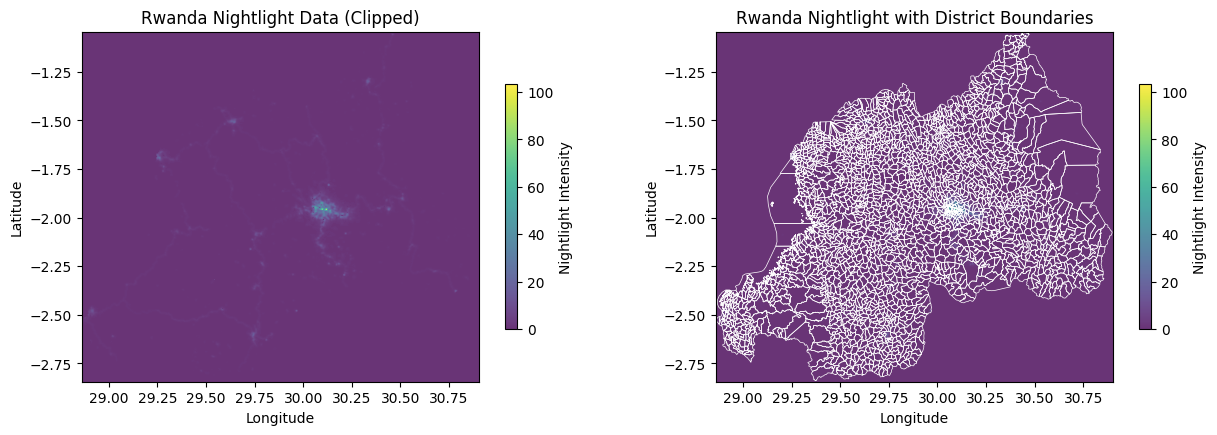

In [59]:
# =========================================
# LOAD AND VISUALIZE THE CLIPPED RASTER
# =========================================

# Load cell boundaries
gdf_adm4 = gpd.read_file(FILE_SHP_ADM4, engine="pyogrio")

with rasterio.open(rwanda_raster_path) as src:
    rwanda_nightlight = src.read(1)
    rwanda_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Clipped raster
plt.subplot(2, 2, 1)
plt.imshow(rwanda_nightlight, extent=rwanda_extent, cmap='viridis', alpha=0.8)
plt.colorbar(label='Nightlight Intensity', shrink=0.7)
plt.title('Rwanda Nightlight Data (Clipped)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot 2: Raster with district boundaries
# Plot 2: Raster with district boundaries
plt.subplot(2, 2, 2)
plt.imshow(rwanda_nightlight, extent=rwanda_extent, cmap='viridis', alpha=0.8)
rwanda_districts_plot = gdf_adm4

rwanda_districts_plot.boundary.plot(ax=plt.gca(), color='white', linewidth=0.5)

plt.colorbar(label='Nightlight Intensity', shrink=0.7)
plt.title('Rwanda Nightlight with District Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

print(type(rwanda_districts_plot))
print(rwanda_districts_plot.geometry.head())

### Generate Cell Level Zonal Statistics

In [60]:
# ===================================================
# GENERATING ZONAL STATISTICS WITH A CUSTOM SCRIPT
# ===================================================

# Create ZonalStatistics object using the clipped Rwanda data with
# the following args
# 1. Path of clipped night lights raster/image: rwanda_raster_path
# 2. Path of administrative boundaries shapefile: FILE_SHP_ADM4
# 3. Administrative level: 4

from rasterstats import zonal_stats
import geopandas as gpd
import rasterio

DIR_WORKSPACE = Path.cwd()
DIR_DATA = DIR_WORKSPACE / "data"
DIR_SRC = DIR_WORKSPACE / "src"

FILE_SHP_ADM4 = DIR_DATA / "geospatial/pop-demo-infra/adm4-pop-buildings.shp"
FILE_RASTER = DIR_DATA / "ntl/VNL_npp_2024_global_vcmslcfg_v2_c202502261200.average_masked.dat.tif"


admin_level = "cell_id"


#with rasterio.open(FILE_RASTER) as src:
#zs = zonal_stats(FILE_RASTER, FILE_SHP_ADM4, admin_level)


# 1. Load admin boundaries
gdf_adm4 = gpd.read_file(FILE_SHP_ADM4, engine="pyogrio")

# 2. Run zonal statistics
#    stats = ["mean", "sum", "min", "max", "median", "std"] → adjust as needed
zs = zonal_stats(
    vectors=gdf_adm4,               # use loaded GeoDataFrame
    raster=str(rwanda_raster_path), # use clipped raster path as string
    stats=["mean", "sum", "min", "max", "median"], 
    geojson_out=True                # return GeoJSON features with geometry
)

# 3. Convert back into a GeoDataFrame
gdf_stats = gpd.GeoDataFrame.from_features(zs, crs=gdf_adm4.crs)

# 4. Inspect
print(gdf_stats.head())

                                            geometry        cell_id  \
0  POLYGON ((29.97630 -1.51480, 29.97330 -1.51440...  RWA.1.1.1.1_1   
1  POLYGON ((29.96730 -1.48260, 29.96160 -1.48070...  RWA.1.1.1.2_1   
2  POLYGON ((29.96100 -1.47140, 29.96290 -1.47340...  RWA.1.1.1.3_1   
3  POLYGON ((29.97130 -1.51330, 29.98110 -1.51650...  RWA.1.1.1.4_1   
4  POLYGON ((29.83940 -1.39180, 29.83870 -1.39370...  RWA.1.1.2.1_1   

     province_n district_n sector_nam cell_name  elderly_60   general_20  \
0  Amajyaruguru     Burera     Bungwe    Bungwe  241.693282  3855.623385   
1  Amajyaruguru     Burera     Bungwe  Bushenya  229.611624  3669.128833   
2  Amajyaruguru     Burera     Bungwe  Mudugari  109.718616  1756.630395   
3  Amajyaruguru     Burera     Bungwe     Tumba  318.065743  5174.177333   
4  Amajyaruguru     Burera     Butaro   Gatsibo  335.976866  6046.478580   

   children_u   youth_15_2     men_2020   women_2020  building_c  min  \
0  495.422606   758.093936  1850.711053  20

In [40]:
# There is no load_data() method for the zs list, so this line should be removed.
# If you want to inspect the zonal statistics, you can print or display the first few entries:
print("First zonal statistics feature:")
print(zs[0])

First zonal statistics feature:
{'id': '0', 'type': 'Feature', 'properties': {'cell_id': 'RWA.1.1.1.1_1', 'province_n': 'Amajyaruguru', 'district_n': 'Burera', 'sector_nam': 'Bungwe', 'cell_name': 'Bungwe', 'elderly_60': 241.69328199999998, 'general_20': 3855.623385, 'children_u': 495.422606, 'youth_15_2': 758.093936, 'men_2020': 1850.711053, 'women_2020': 2004.9123319999999, 'building_c': 1435.0, 'min': 0.0, 'max': 0.0, 'mean': 0.0, 'sum': 0.0, 'median': 0.0}, 'geometry': {'type': 'Polygon', 'coordinates': (((29.9763, -1.5148), (29.9733, -1.5144), (29.9691, -1.5109), (29.9713, -1.502), (29.9674, -1.495), (29.9623, -1.4919), (29.9612, -1.4833), (29.962, -1.4808), (29.966, -1.4828), (29.9702, -1.4824), (29.98, -1.4765), (29.9834, -1.4861), (29.9781, -1.4885), (29.9756, -1.4916), (29.9807, -1.5015), (29.9833, -1.5014), (29.9834, -1.5039), (29.9805, -1.5089), (29.9817, -1.5161), (29.9763, -1.5148)),)}, 'bbox': (29.9612, -1.5161, 29.9834, -1.4765)}


In [61]:
# =======================================
# DEFINE WHICH STATISTICS TO CALCULATE
# =======================================
stats_to_calculate = ['mean', 'median', 'count', "sum"]

print(f"Calculating statistics: {stats_to_calculate}")
print("This may take a few minutes depending on data size...")

# The zonal statistics have already been calculated and stored in gdf_stats
df_stats = gdf_stats.copy()

# Display results
print(f"\nAnalysis complete! Results shape: {df_stats.shape}")
display(df_stats.head(10))

Calculating statistics: ['mean', 'median', 'count', 'sum']
This may take a few minutes depending on data size...

Analysis complete! Results shape: (2169, 18)


,geometry,cell_id,province_n,district_n,sector_nam,cell_name,elderly_60,general_20,children_u,youth_15_2,men_2020,women_2020,building_c,min,max,mean,sum,median
0,"POLYGON ((29.97630 -1.51480, 29.97330 -1.51440...",RWA.1.1.1.1_1,Amajyaruguru,Burera,Bungwe,Bungwe,241.693282,3855.623385,495.422606,758.093936,1850.711053,2004.912332,1435.0,0.0,0.000000,0.000000,0.000000,0.00000
1,"POLYGON ((29.96730 -1.48260, 29.96160 -1.48070...",RWA.1.1.1.2_1,Amajyaruguru,Burera,Bungwe,Bushenya,229.611624,3669.128833,470.655098,720.896415,1761.457437,1907.671396,884.0,0.0,0.000000,0.000000,0.000000,0.00000
2,"POLYGON ((29.96100 -1.47140, 29.96290 -1.47340...",RWA.1.1.1.3_1,Amajyaruguru,Burera,Bungwe,Mudugari,109.718616,1756.630395,225.188715,345.073314,843.263769,913.366626,530.0,0.0,0.000000,0.000000,0.000000,0.00000
3,"POLYGON ((29.97130 -1.51330, 29.98110 -1.51650...",RWA.1.1.1.4_1,Amajyaruguru,Burera,Bungwe,Tumba,318.065743,5174.177333,666.434701,1016.066328,2482.353880,2691.823510,1512.0,0.0,0.000000,0.000000,0.000000,0.00000
4,"POLYGON ((29.83940 -1.39180, 29.83870 -1.39370...",RWA.1.1.2.1_1,Amajyaruguru,Burera,Butaro,Gatsibo,335.976866,6046.478580,833.994018,1264.716616,2880.475354,3166.003226,2036.0,0.0,0.972752,0.028464,1.935569,0.00000
5,"POLYGON ((29.86290 -1.42610, 29.85740 -1.42960...",RWA.1.1.2.2_1,Amajyaruguru,Burera,Butaro,Mubuga,252.544408,4546.095230,627.539964,950.901218,2166.029512,2380.065718,1245.0,0.0,4.061617,0.759367,31.134054,0.55762
6,"POLYGON ((29.87000 -1.44420, 29.86100 -1.45230...",RWA.1.1.2.3_1,Amajyaruguru,Burera,Butaro,Muhotora,242.607319,4378.195050,604.810057,915.834094,2084.280921,2293.914184,1028.0,0.0,0.000000,0.000000,0.000000,0.00000
7,"POLYGON ((29.86260 -1.40070, 29.85970 -1.39320...",RWA.1.1.2.4_1,Amajyaruguru,Burera,Butaro,Nyamicucu,394.154718,7223.191175,1014.994726,1509.730864,3432.863438,3790.327816,2164.0,0.0,0.467896,0.005999,0.467896,0.00000
8,"POLYGON ((29.84500 -1.40770, 29.84390 -1.41490...",RWA.1.1.2.5_1,Amajyaruguru,Burera,Butaro,Rusumo,505.546608,9103.058860,1255.289340,1904.912436,4339.551680,4763.507180,2600.0,0.0,2.072214,0.382928,18.763454,0.00000
9,"POLYGON ((29.72700 -1.40130, 29.72730 -1.40800...",RWA.1.1.3.1_1,Amajyaruguru,Burera,Cyanika,Gasiza,314.335879,5558.767970,802.327779,1204.339182,2701.282634,2857.485336,1275.0,0.0,0.000000,0.000000,0.000000,0.00000


In [62]:
print(df_stats.columns.tolist())

['geometry', 'cell_id', 'province_n', 'district_n', 'sector_nam', 'cell_name', 'elderly_60', 'general_20', 'children_u', 'youth_15_2', 'men_2020', 'women_2020', 'building_c', 'min', 'max', 'mean', 'sum', 'median']


In [63]:
print(gdf_adm4.columns.tolist())

['cell_id', 'province_n', 'district_n', 'sector_nam', 'cell_name', 'elderly_60', 'general_20', 'children_u', 'youth_15_2', 'men_2020', 'women_2020', 'building_c', 'geometry']


In [64]:
# ==================================================
# SAVE RESULTS
# ==================================================

# Merge using 'cell_id' as the key, not 'geometry'
cols2keep = ['cell_id', 'province_n', 'district_n', 'sector_nam', 'cell_name']
df_stats2 = df_stats.merge(gdf_adm4[cols2keep], on='cell_id', how='left')

# After merge, columns have suffixes (_x, _y). Use the correct ones.
# The statistics columns are: 'mean', 'median', 'sum'
# There is no 'count' column, so we drop it from cols2save.

cols2save_actual = ['province_n_x', 'district_n_x', 'sector_nam_x', 'cell_name_x', 'mean', 'median', 'sum']

# Optionally, rename columns for output
df_out = df_stats2[cols2save_actual].rename(columns={
    'province_n_x': 'province_n',
    'district_n_x': 'district_n',
    'sector_nam_x': 'sector_nam',
    'cell_name_x': 'cell_name'
})

df_out.to_csv(DIR_DATA / "ntl/rw-adm4-ntl-stats.csv", index=False)
print("Saved zonal statistics to:", DIR_DATA / "ntl/rw-adm4-ntl-stats.csv")

Saved zonal statistics to: /Users/ekayitaba/Documents/GitHub/nightlight-analysis-emmanuel.kayitaba/data/ntl/rw-adm4-ntl-stats.csv


In [52]:
## Report on Cells with Largest Night Light Values
largest_cells = df_stats2.nlargest(10, 'mean')
print("Cells with the largest night light values:")
display(largest_cells)

Cells with the largest night light values:


,geometry,cell_id_x,province_n_x,district_n_x,sector_nam_x,cell_name_x,elderly_60,general_20,children_u,youth_15_2,...,min,max,mean,sum,median,cell_id_y,province_n_y,district_n_y,sector_nam_y,cell_name_y
2066,"POLYGON ((30.12370 -1.95800, 30.12460 -1.95660...",RWA.5.1.13.4_1,UmujyiwaKigali,Gasabo,Remera,RukiriIi,201.055299,11272.074693,1364.402687,2888.830244,...,28.892834,103.279572,63.279951,442.959656,63.432415,NaN,NaN,NaN,NaN,NaN
2042,"POLYGON ((30.08840 -1.96290, 30.08460 -1.95770...",RWA.5.1.8.3_1,UmujyiwaKigali,Gasabo,Kimihurura,Rugando,152.512582,8278.934037,902.393296,2119.468798,...,19.071976,96.333199,55.100793,551.007935,53.704506,NaN,NaN,NaN,NaN,NaN
2147,"POLYGON ((30.06250 -1.93880, 30.06450 -1.94070...",RWA.5.3.6.2_1,UmujyiwaKigali,Nyarugenge,Muhima,Kabasengerezi,65.522006,2161.198864,196.824433,576.154349,...,46.672283,46.672283,46.672283,46.672283,46.672283,NaN,NaN,NaN,NaN,NaN
2163,"POLYGON ((30.06750 -1.96690, 30.06540 -1.96350...",RWA.5.3.9.3_1,UmujyiwaKigali,Nyarugenge,Nyarugenge,Kiyovu,356.973807,12463.451852,1268.659567,3282.253678,...,23.583921,55.175167,39.408813,709.358643,39.498615,NaN,NaN,NaN,NaN,NaN
2040,"POLYGON ((30.09300 -1.94900, 30.09550 -1.94900...",RWA.5.1.8.1_1,UmujyiwaKigali,Gasabo,Kimihurura,Kamukina,86.834564,4524.901524,474.189314,1152.471891,...,25.480043,52.793953,38.576935,231.461609,37.817230,NaN,NaN,NaN,NaN,NaN
2161,"POLYGON ((30.06700 -1.97050, 30.06360 -1.97160...",RWA.5.3.9.1_1,UmujyiwaKigali,Nyarugenge,Nyarugenge,Agatare,28.409994,1201.447956,135.761103,310.684824,...,32.330547,41.552189,36.941368,73.882736,36.941368,NaN,NaN,NaN,NaN,NaN
2152,"POLYGON ((30.07430 -1.94560, 30.07690 -1.95480...",RWA.5.3.6.7_1,UmujyiwaKigali,Nyarugenge,Muhima,Ubumwe,73.946324,2567.341080,243.047000,688.472168,...,27.161840,47.710457,36.052862,108.158585,33.286285,NaN,NaN,NaN,NaN,NaN
2150,"POLYGON ((30.07140 -1.94620, 30.07140 -1.94750...",RWA.5.3.6.5_1,UmujyiwaKigali,Nyarugenge,Muhima,Rugenge,147.333692,4866.888356,434.896371,1300.118104,...,28.251236,43.445023,35.706340,107.119019,35.422756,NaN,NaN,NaN,NaN,NaN
2065,"POLYGON ((30.10310 -1.96600, 30.10080 -1.96890...",RWA.5.1.13.3_1,UmujyiwaKigali,Gasabo,Remera,RukiriI,206.060870,11680.554134,1302.640791,3098.237649,...,28.641529,39.694599,34.764243,173.821213,34.497875,NaN,NaN,NaN,NaN,NaN
2063,"POLYGON ((30.11240 -1.95510, 30.10970 -1.95850...",RWA.5.1.13.1_1,UmujyiwaKigali,Gasabo,Remera,Nyabisindu,203.323424,11779.107476,1449.264628,2973.516404,...,17.776976,65.388702,34.394904,240.764328,28.476431,NaN,NaN,NaN,NaN,NaN
